In [60]:
#Import Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

# Openpyxl refuses to open files if UserWarnings are not ignored
# See https://stackoverflow.com/questions/54976991/python-openpyxl-userwarning-unknown-extension-issue
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

In [61]:
#Import the file from the ERP
erp = pd.read_excel('Fichier_erp.xlsx')

#Import the file from the product table of our online sales platform
web = pd.read_excel('Fichier_web.xlsx')

#Import the file which lists the ERP product_ids with their web references
liaison = pd.read_excel('fichier_liaison.xlsx')

### Exploration of the 'Liaison' file

In [62]:
#Display the shape of the liaison file
liaison.shape

(825, 2)

In [63]:
#Display head of dataframe
display(liaison.head())

product_id id_web
0        3847  15298
1        3849  15296
2        3850  15300
3        4032  19814
4        4039  19815

In [64]:
#Check data types
liaison.dtypes

product_id     int64
id_web        object
dtype: object

In [65]:
#Some SKUs have non-standard shapes.
id_web_outliers = liaison[pd.to_numeric(liaison['id_web'], errors='coerce').isna()]
id_web_outliers['id_web'].unique()

array([nan, 'bon-cadeau-25-euros', '13127-1', '14680-1'], dtype=object)

While these are unexpected skus, they are not outliers. Given this, I will keep them in the dataset.

In [66]:
#Check if the liaison file has missing values
print(liaison.isnull().sum())

product_id     0
id_web        91
dtype: int64


This is what Sylvie mentioned when she said - "The list of product_ids is exhaustive, but for the references on the Web side, I am less sure... I struggled to reconcile certain references." As we are looking at products sold online, I have removed the rows where we do not have a web ID for the products.

In [67]:
#Remove rows where id_web = nan
liaison = liaison.dropna(subset=['id_web'])

In [68]:
#Find duplicates for product_id
print(liaison.loc[liaison['product_id'].duplicated(keep=False),:])

Empty DataFrame
Columns: [product_id, id_web]
Index: []


In [69]:
#Find duplicates for web_id
print(liaison.loc[liaison['id_web'].duplicated(keep=False),:])

Empty DataFrame
Columns: [product_id, id_web]
Index: []


In [70]:
#Search for outliers
liaison.describe()

product_id
count   734.000000
mean   5041.859673
std     790.309295
min    3847.000000
25%    4287.250000
50%    4862.500000
75%    5714.250000
max    7338.000000

No duplicates in both columns.

Sylvie mentioned that she forgot to name the sku of the id_web column, so I'll rename it here.

In [71]:
#Rename column id_web to sku
liaison = liaison.rename(columns={'id_web': 'sku'})

In [72]:
#Check if the product_id column can be used as a primary key
print("Unique values in product_id column =", liaison['product_id'].nunique())
print("Liaison shape =", liaison.shape)

Unique values in product_id column = 734
Liaison shape = (734, 2)


### Exploration of the 'Web' file

In [73]:
#Show the shape of the file
web.shape

(1513, 28)

In [74]:
#Change options to show all columns in the dataframe
pd.set_option('display.max_columns', None)

#Print the head of the dataframe
display(web.head())

sku  virtual  downloadable  rating_count  average_rating  total_sales  \
0   38        0             0             0             0.0         38.0   
1   38        0             0             0             0.0         38.0   
2   41        0             0             0             0.0          0.0   
3   41        0             0             0             0.0          0.0   
4  304        0             0             0             0.0         40.0   

  tax_status  tax_class  post_author           post_date       post_date_gmt  \
0    taxable        NaN          2.0 2018-04-18 12:25:58 2018-04-18 10:25:58   
1        NaN        NaN          2.0 2018-04-18 12:25:58 2018-04-18 10:25:58   
2        NaN        NaN          2.0 2018-04-14 12:01:43 2018-04-14 10:01:43   
3    taxable        NaN          2.0 2018-04-14 12:01:43 2018-04-14 10:01:43   
4    taxable        NaN          2.0 2018-02-13 12:57:44 2018-02-13 11:57:44   

   post_content                                         post_title  \
0           NaN         Emile Boeckel Crémant Brut Blanc de Blancs   
1           NaN         Emile Boeckel Crémant Brut Blanc de Blancs   
2           NaN  Marcel Windholtz Eau de Vie de Marc de Gewurzt...   
3           NaN  Marcel Windholtz Eau de Vie de Marc de Gewurzt...   
4           NaN                    Champagne Gosset Grande Réserve   

                                        post_excerpt post_status  \
0  Ce Crémant est vif et délicat, gourmand et cro...     publish   
1                                                NaN     publish   
2                                                NaN     publish   
3  Les eaux de vie naissent d'une subtile alchimi...     publish   
4  Le nez, ouvert et expressif, évoque les fruits...     publish   

  comment_status ping_status  post_password  \
0         closed      closed            NaN   
1         closed      closed            NaN   
2         closed      closed            NaN   
3         closed      closed            NaN   
4         closed      closed            NaN   

                                        post_name       post_modified  \
0      emile-boeckel-cremant-brut-blanc-de-blancs 2020-08-27 17:15:03   
1      emile-boeckel-cremant-brut-blanc-de-blancs 2020-08-27 17:15:03   
2  marcel-windholtz-eau-de-marc-de-gewurztraminer 2020-08-03 10:25:02   
3  marcel-windholtz-eau-de-marc-de-gewurztraminer 2020-08-03 10:25:02   
4                 gosset-champagne-grande-reserve 2020-08-27 11:25:02   

    post_modified_gmt  post_content_filtered  post_parent  \
0 2020-08-27 15:15:03                    NaN          0.0   
1 2020-08-27 15:15:03                    NaN          0.0   
2 2020-08-03 08:25:02                    NaN          0.0   
3 2020-08-03 08:25:02                    NaN          0.0   
4 2020-08-27 09:25:02                    NaN          0.0   

                                                guid  menu_order   post_type  \
0  https://www.bottle-neck.fr/?post_type=product&...         0.0     product   
1  https://www.bottle-neck.fr/wp-content/uploads/...         0.0  attachment   
2  https://www.bottle-neck.fr/wp-content/uploads/...         0.0  attachment   
3  https://www.bottle-neck.fr/?post_type=product&...         0.0     product   
4  https://www.bottle-neck.fr/?post_type=product&...         0.0     product   

  post_mime_type  comment_count  
0            NaN            0.0  
1     image/jpeg            0.0  
2     image/jpeg            0.0  
3            NaN            0.0  
4            NaN            0.0

In [75]:
#Check to see if there are any errors in terms of data type
web.dtypes

sku                              object
virtual                           int64
downloadable                      int64
rating_count                      int64
average_rating                  float64
total_sales                     float64
tax_status                       object
tax_class                       float64
post_author                     float64
post_date                datetime64[ns]
post_date_gmt            datetime64[ns]
post_content                    float64
post_title                       object
post_excerpt                     object
post_status                      object
comment_status                   object
ping_status                      object
post_password                   float64
post_name                        object
post_modified            datetime64[ns]
post_modified_gmt        datetime64[ns]
post_content_filtered           float64
post_parent                     float64
guid                             object
menu_order                      float64


In [76]:
#Check the values in the post_author column
web['post_author'].unique()

array([ 2.,  1., nan])

- Total Sales - As sales can only be counted in integers, I need to change the float type to integer.
- Post author - Since there are only two values for author (i.e. author 1 or 2), I need to change it entirely.

In [77]:
#The total_sales column is a float when it should be an integer. Change Total Sales column to integer - fill in NaN, then change type
web['total_sales'] = web['total_sales'].fillna(0)
web['total_sales'] = web['total_sales'].astype(int)

# The post_author column is a float when it should be an integer. Change post author column to integer - fill NaN, then change type
web['post_author'] = web['post_author'].fillna(0)
web['post_author'] = web['post_author'].astype(int)

In [78]:
#Check if the file 'Web' contains missing values
web_na = web.isnull().sum()
web_na[web_na>0]

sku                        85
average_rating             83
tax_status                797
tax_class                1513
post_date                  83
post_date_gmt              83
post_content             1513
post_title                 83
post_excerpt              797
post_status                83
comment_status             83
ping_status                83
post_password            1513
post_name                  83
post_modified              83
post_modified_gmt          83
post_content_filtered    1513
post_parent                83
guid                       83
menu_order                 83
post_type                  83
post_mime_type            799
comment_count              83
dtype: int64

In [79]:
#Remove all columns with all values missing
web = web.drop(columns=['tax_class', 'post_content', 'post_password', 'post_content_filtered'])

In [80]:
#Check rows where there is no sku, but there are values for other columns
web.loc[(web['sku'].isnull()) & (~web['post_date'].isnull())]

sku  virtual  downloadable  rating_count  average_rating  total_sales  \
1445  NaN        0             0             0             0.0            3   
1454  NaN        0             0             0             0.0           10   

     tax_status  post_author           post_date       post_date_gmt  \
1445    taxable            2 2018-08-08 11:23:43 2018-08-08 09:23:43   
1454    taxable            2 2018-07-31 12:07:23 2018-07-31 10:07:23   

                                           post_title  \
1445  Pierre Jean Villa Condrieu Jardin Suspendu 2018   
1454       Pierre Jean Villa Côte Rôtie Fongeant 2017   

                                           post_excerpt post_status  \
1445  <span id="u1194-83">Le nez séduit par ses parf...     publish   
1454  Fongeant 2017 explose sur un fruit brillant, p...     publish   

     comment_status ping_status                                   post_name  \
1445         closed      closed    pierre-jean-villa-condrieu-suspendu-2018   
1454         closed      closed  pierre-jean-villa-cote-rotie-fongeant-2017   

           post_modified   post_modified_gmt  post_parent  \
1445 2019-11-02 13:24:01 2019-11-02 12:24:01          0.0   
1454 2019-11-02 13:24:15 2019-11-02 12:24:15          0.0   

                                                   guid  menu_order post_type  \
1445  https://www.bottle-neck.fr/?post_type=product&...         0.0   product   
1454  https://www.bottle-neck.fr/?post_type=product&...         0.0   product   

     post_mime_type  comment_count  
1445            NaN            0.0  
1454            NaN            0.0

In [81]:
#Check if I can find duplicates for the post_titles for these rows in order to find matching skus.
display(web.loc[web['post_title']== 'Pierre Jean Villa Condrieu Jardin Suspendu 2018'])
display(web.loc[web['post_title']== 'Pierre Jean Villa Côte Rôtie Fongeant 2017'])

sku  virtual  downloadable  rating_count  average_rating  total_sales  \
1445  NaN        0             0             0             0.0            3   

     tax_status  post_author           post_date       post_date_gmt  \
1445    taxable            2 2018-08-08 11:23:43 2018-08-08 09:23:43   

                                           post_title  \
1445  Pierre Jean Villa Condrieu Jardin Suspendu 2018   

                                           post_excerpt post_status  \
1445  <span id="u1194-83">Le nez séduit par ses parf...     publish   

     comment_status ping_status                                 post_name  \
1445         closed      closed  pierre-jean-villa-condrieu-suspendu-2018   

           post_modified   post_modified_gmt  post_parent  \
1445 2019-11-02 13:24:01 2019-11-02 12:24:01          0.0   

                                                   guid  menu_order post_type  \
1445  https://www.bottle-neck.fr/?post_type=product&...         0.0   product   

     post_mime_type  comment_count  
1445            NaN            0.0

sku  virtual  downloadable  rating_count  average_rating  total_sales  \
1454  NaN        0             0             0             0.0           10   

     tax_status  post_author           post_date       post_date_gmt  \
1454    taxable            2 2018-07-31 12:07:23 2018-07-31 10:07:23   

                                      post_title  \
1454  Pierre Jean Villa Côte Rôtie Fongeant 2017   

                                           post_excerpt post_status  \
1454  Fongeant 2017 explose sur un fruit brillant, p...     publish   

     comment_status ping_status                                   post_name  \
1454         closed      closed  pierre-jean-villa-cote-rotie-fongeant-2017   

           post_modified   post_modified_gmt  post_parent  \
1454 2019-11-02 13:24:15 2019-11-02 12:24:15          0.0   

                                                   guid  menu_order post_type  \
1454  https://www.bottle-neck.fr/?post_type=product&...         0.0   product   

     post_mime_type  comment_count  
1454            NaN            0.0

In [82]:
#No match for 2 rows with data but no SKU, so I will remove all rows with null values for the sku column
web = web.dropna(subset=['sku'])

In [83]:
##Check if the 'Web' file contains missing values
web.isnull().sum()

sku                    0
virtual                0
downloadable           0
rating_count           0
average_rating         0
total_sales            0
tax_status           714
post_author            0
post_date              0
post_date_gmt          0
post_title             0
post_excerpt         714
post_status            0
comment_status         0
ping_status            0
post_name              0
post_modified          0
post_modified_gmt      0
post_parent            0
guid                   0
menu_order             0
post_type              0
post_mime_type       714
comment_count          0
dtype: int64

In [84]:
#Check if their are any duplicates
web.loc[web['sku'].duplicated(keep=False),:]

sku  virtual  downloadable  rating_count  \
0                      38        0             0             0   
1                      38        0             0             0   
2                      41        0             0             0   
3                      41        0             0             0   
4                     304        0             0             0   
...                   ...      ...           ...           ...   
1423                19822        0             0             0   
1424              13127-1        0             0             0   
1425              13127-1        0             0             0   
1426  bon-cadeau-25-euros        0             0             0   
1427  bon-cadeau-25-euros        0             0             0   

      average_rating  total_sales tax_status  post_author           post_date  \
0                0.0           38    taxable            2 2018-04-18 12:25:58   
1                0.0           38        NaN            2 2018-04-18 12:25:58   
2                0.0            0        NaN            2 2018-04-14 12:01:43   
3                0.0            0    taxable            2 2018-04-14 12:01:43   
4                0.0           40    taxable            2 2018-02-13 12:57:44   
...              ...          ...        ...          ...                 ...   
1423             0.0            0    taxable            2 2018-11-26 10:59:10   
1424             0.0            0        NaN            2 2020-06-09 15:42:04   
1425             0.0            0    taxable            2 2020-06-09 15:42:04   
1426             0.0           10    taxable            1 2018-06-01 13:53:46   
1427             0.0           10        NaN            1 2018-06-01 13:53:46   

           post_date_gmt                                         post_title  \
0    2018-04-18 10:25:58         Emile Boeckel Crémant Brut Blanc de Blancs   
1    2018-04-18 10:25:58         Emile Boeckel Crémant Brut Blanc de Blancs   
2    2018-04-14 10:01:43  Marcel Windholtz Eau de Vie de Marc de Gewurzt...   
3    2018-04-14 10:01:43  Marcel Windholtz Eau de Vie de Marc de Gewurzt...   
4    2018-02-13 11:57:44                    Champagne Gosset Grande Réserve   
...                  ...                                                ...   
1423 2018-11-26 09:59:10                      Tempier Bandol Cabassaou 2017   
1424 2020-06-09 13:42:04       Clos du Mont-Olivet Châteauneuf-du-Pape 2007   
1425 2020-06-09 13:42:04       Clos du Mont-Olivet Châteauneuf-du-Pape 2007   
1426 2018-06-01 11:53:46                                  Bon cadeau de 25€   
1427 2018-06-01 11:53:46                                  Bon cadeau de 25€   

                                           post_excerpt post_status  \
0     Ce Crémant est vif et délicat, gourmand et cro...     publish   
1                                                   NaN     publish   
2                                                   NaN     publish   
3     Les eaux de vie naissent d'une subtile alchimi...     publish   
4     Le nez, ouvert et expressif, évoque les fruits...     publish   
...                                                 ...         ...   
1423  <div id="wrapper">\n<div id="container-wrapper...     publish   
1424                                                NaN     publish   
1425  Nez gracieux, très élégant avec une touche flo...     publish   
1426  <span style="color: #a85253;"><strong>Parlons ...     publish   
1427                                                NaN     publish   

     comment_status ping_status  \
0            closed      closed   
1            closed      closed   
2            closed      closed   
3            closed      closed   
4            closed      closed   
...             ...         ...   
1423         closed      closed   
1424         closed      closed   
1425         closed      closed   
1426         closed      closed   
1427         closed      closed   

                                 

In [85]:
#Check the values in post_type
web['post_type'].unique()

array(['product', 'attachment'], dtype=object)

There are duplicates because for products there are 'attachment' and 'product' post types. I need to remove all rows with attachment as a value in post_type.

In [86]:
# Remove all rows with 'attachment' as value in post_type column
web = web[web['post_type'] != 'attachment']
#Check for duplicates
web.loc[web[['sku', 'post_title']].duplicated(keep=False),:]

Empty DataFrame
Columns: [sku, virtual, downloadable, rating_count, average_rating, total_sales, tax_status, post_author, post_date, post_date_gmt, post_title, post_excerpt, post_status, comment_status, ping_status, post_name, post_modified, post_modified_gmt, post_parent, guid, menu_order, post_type, post_mime_type, comment_count]
Index: []

In [87]:
#Identify columns with all 0 or nan values and check for outliers
web.describe()

virtual  downloadable  rating_count  average_rating  total_sales  \
count    714.0         714.0         714.0           714.0   714.000000   
mean       0.0           0.0           0.0             0.0     4.012605   
min        0.0           0.0           0.0             0.0     0.000000   
25%        0.0           0.0           0.0             0.0     0.000000   
50%        0.0           0.0           0.0             0.0     1.000000   
75%        0.0           0.0           0.0             0.0     4.000000   
max        0.0           0.0           0.0             0.0    96.000000   
std        0.0           0.0           0.0             0.0     8.518183   

       post_author                      post_date  \
count   714.000000                            714   
mean      1.998599  2018-08-22 03:57:52.950980608   
min       1.000000            2018-02-08 12:58:52   
25%       2.000000     2018-02-27 20:01:12.500000   
50%       2.000000            2018-04-19 14:52:10   
75%       2.000000            2019-01-31 14:35:47   
max       2.000000            2020-07-20 11:00:00   
std       0.037424                            NaN   

                       post_date_gmt                  post_modified  \
count                            714                            714   
mean   2018-08-22 02:29:08.581232640  2020-06-20 21:45:25.694677760   
min              2018-02-08 11:58:52            2018-02-20 15:19:23   
25%       2018-02-27 19:01:12.500000            2020-06-18 18:32:35   
50%              2018-04-19 12:52:10     2020-08-04 09:30:06.500000   
75%              2019-01-31 13:35:47            2020-08-25 10:32:32   
max              2020-07-20 09:00:00            2020-08-27 18:55:03   
std                              NaN                            NaN   

                   post_modified_gmt  post_parent  menu_order  comment_count  
count                            714        714.0       714.0          714.0  
mean   2020-06-20 19:51:53.929971968          0.0         0.0            0.0  
min              2018-02-20 14:19:23          0.0         0.0            0.0  
25%              2020-06-18 16:32:35          0.0         0.0            0.0  
50%       2020-08-04 07:30:06.500000          0.0         0.0            0.0  
75%              2020-08-25 08:32:32          0.0         0.0            0.0  
max              2020-08-27 16:55:03          0.0         0.0            0.0  
std                              NaN          0.0         0.0            0.0

In [88]:
#Delete all columns where all values are 0 or null
web = web.drop(columns=['virtual', 'downloadable', 'rating_count', 'average_rating', 'post_parent', 'menu_order', 'comment_count'])
#Delete columns that will not be used for the analysis
web = web.drop(columns=['tax_status', 'post_author', 'post_date', 'post_date_gmt', 'post_excerpt', 'comment_status', 'ping_status', 'post_name', 'post_modified', 'post_modified_gmt', 'guid', 'post_type', 'post_status', 'post_mime_type']).reset_index().drop(columns='index')

In [89]:
#Determine if SKU can be used as a primary key
print("Valeurs uniques dans la colonne SKU = ", web['sku'].nunique())
print("Web shape =", web.shape)

Valeurs uniques dans la colonne SKU =  714
Web shape = (714, 3)


In [90]:
web.head()

sku  total_sales                                         post_title
0   38           38         Emile Boeckel Crémant Brut Blanc de Blancs
1   41            0  Marcel Windholtz Eau de Vie de Marc de Gewurzt...
2  304           40                    Champagne Gosset Grande Réserve
3  523            0                       Cognac Normandin Mercier VFC
4  531           13  Champagne Petit Lebrun &amp; Fils Blanc de Bla...

### Exploration of the ERP file

In [91]:
#Explore the 'ERP' file
display(erp.head())

erp.shape

product_id  onsale_web  price  stock_quantity stock_status
0        3847           1   24.2               0   outofstock
1        3849           1   34.3               0   outofstock
2        3850           1   20.8               0   outofstock
3        4032           1   14.1               0   outofstock
4        4039           1   46.0               0   outofstock

(825, 5)

In [92]:
#Verify if there are any type errors
erp.dtypes

product_id          int64
onsale_web          int64
price             float64
stock_quantity      int64
stock_status       object
dtype: object

In [93]:
#Check if the 'ERP' file has any missing values
erp.isnull().sum()

product_id        0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
dtype: int64

In [94]:
#Check whether there are any duplicates
erp.loc[erp['product_id'].duplicated(keep=False),:]

Empty DataFrame
Columns: [product_id, onsale_web, price, stock_quantity, stock_status]
Index: []

In [95]:
#Check for outliers 
erp.describe()

product_id  onsale_web       price  stock_quantity
count   825.000000  825.000000  825.000000      825.000000
mean   5162.597576    0.869091   32.384000       26.583030
std     902.644635    0.337506   26.832271       45.875948
min    3847.000000    0.000000   -8.000000       -1.000000
25%    4348.000000    1.000000   14.600000        1.000000
50%    4907.000000    1.000000   24.400000       11.000000
75%    5805.000000    1.000000   42.000000       34.000000
max    7338.000000    1.000000  225.000000      578.000000

There are aberrantes values for price and stock_quantity - negative values can't exist, as we can't sell products for negative prices or have negative amounts of stock. I will start by checking the outliers for price.

In [96]:
#Locate the rows with outliers for price
erp.loc[erp['price']<0]

product_id  onsale_web  price  stock_quantity stock_status
469        5017           0   -8.0               0   outofstock
739        6594           0   -1.0             192      instock

In [97]:
#As we are interested in analysing price and revenue, we need to remove the rows with negative prices.
erp = erp[erp['price']>0]

Now, I can check the rows with outliers for stock quantity and compare them to the stock status columns.

In [98]:
#Check the values in the stock_status column
print('Stock_status values =', erp['stock_status'].unique())

Stock_status values = ['outofstock' 'instock']


In [99]:
#Find the negative values in the stock_quantity column
display(erp.loc[erp['stock_quantity']<0,:])


product_id  onsale_web  price  stock_quantity stock_status
449        4973           0   10.0              -1   outofstock
573        5700           1   44.5              -1   outofstock

In [100]:
#Replace the negative values with a zero, as the stock status is 'out_of_stock'
erp.loc[erp['stock_quantity']<0,'stock_quantity'] = 0

In [101]:
#Identify where the stock quantity is 0 but the stock status is 'instock'
erp.loc[(erp['stock_quantity'] == 0) & (erp['stock_status'] == 'instock')]

product_id  onsale_web  price  stock_quantity stock_status
443        4954           1   25.0               0      instock

In [102]:
#Change the stock_status to 'outofstock'
mask = (erp['stock_quantity'] == 0) & (erp['stock_status'] == 'instock')
erp.loc[mask, 'stock_status'] = 'outofstock'

In [103]:
#Identify rows where the stock quantiy is more than 0 but the stock status is 'outofstock'
erp.loc[(erp['stock_quantity'] > 0) & (erp['stock_status'] == 'outofstock')]

product_id  onsale_web  price  stock_quantity stock_status
19         4055           0   86.1               1   outofstock
49         4090           0   73.0               6   outofstock
50         4092           0   47.0               6   outofstock
630        5826           1   41.2              12   outofstock
696        6125           0   14.2              48   outofstock

In [104]:
#Change the stock status to 'instock' if the stock quantity is greater than 0
mask = (erp['stock_quantity'] > 0) & (erp['stock_status'] == 'outofstock')
erp.loc[mask, 'stock_status'] = 'instock'

In [105]:
#Determine if the product ID can be used as a primary key
print("Valeurs uniques dans la colonne product_id = ", erp['product_id'].nunique())
print("ERP shape =", erp.shape)

Valeurs uniques dans la colonne product_id =  823
ERP shape = (823, 5)


### Merge dataframes

In [106]:
#Check the shape of each dataframe
print('Web shape =', web.shape)
print('Liaison shape =', liaison.shape)
print('ERP shape =', erp.shape)

Web shape = (714, 3)
Liaison shape = (734, 2)
ERP shape = (823, 5)


In [107]:
#Merge the dataframes
erp_liaison = pd.merge(erp, liaison, on='product_id', how='left')
erp_web = pd.merge(erp_liaison, web, on='sku', how='inner')

#Check the new dataframe
print('erp_web dataframe shape =', erp_web.shape)
display(erp_web.head())

erp_web dataframe shape = (714, 8)


product_id  onsale_web  price  stock_quantity stock_status    sku  \
0        3847           1   24.2               0   outofstock  15298   
1        3849           1   34.3               0   outofstock  15296   
2        3850           1   20.8               0   outofstock  15300   
3        4032           1   14.1               0   outofstock  19814   
4        4039           1   46.0               0   outofstock  19815   

   total_sales                                         post_title  
0            6        Pierre Jean Villa Saint-Joseph Préface 2018  
1            0    Pierre Jean Villa Saint-Joseph Rouge Tildé 2017  
2            0  Pierre Jean Villa Crozes-Hermitage Accroche Co...  
3            3  Pierre Jean Villa IGP Collines Rhodaniennes Ga...  
4            0          Pierre Jean Villa Côte Rôtie Carmina 2017

In [108]:
#Check if there are any null values
erp_web.isnull().sum()

product_id        0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
sku               0
total_sales       0
post_title        0
dtype: int64

In [119]:
#Create a 'revenue' column  
erp_web['revenue'] = erp_web['price']*erp_web['total_sales']
#Calculate total revenue
ca_totale_enligne = erp_web.loc[erp_web['onsale_web']==1]
ca_totale_enligne = round(ca_totale_enligne['revenue'].sum(),2)

print('Total online revenue is €', ca_totale_enligne)

Total online revenue is € 70568.6


In [120]:
#Show the revenue for each product
CA = erp_web[['post_title', 'price', 'revenue']]
CA = CA.sort_values(by='revenue', ascending=False)
CA_nonulls = CA[~CA['revenue'].isnull()]
CA_nonulls.head(10)

post_title  price  revenue
194             Champagne Gosset Grand Blanc de Blancs   49.0   4704.0
71                         Champagne Gosset Grand Rosé   49.0   4263.0
218                               Cognac Frapin VIP XO  176.0   2288.0
70               Champagne Gosset Grand Millésime 2006   53.0   1590.0
69                     Champagne Gosset Grande Réserve   39.0   1560.0
201     Champagne Egly-Ouriet Grand Cru Blanc de Noirs  126.5   1391.5
199     Champagne Egly-Ouriet Grand Cru Millésimé 2008  225.0   1125.0
79    Elian Daros Côtes du Marmandais Clos Baquey 2015   29.0   1044.0
651           Domaine Giudicelli Patrimonio Blanc 2019   25.2   1033.2
30   Gilles Robin Crozes-Hermitage Rouge Papillon 2019   16.6   1029.2

In [121]:
#Find the percentage of our total revenue produced by our top 3 products
print('Our top 3 products contribute to', round(((4704+4263+2288)/70568.6)*100, 2), "% of our total revenue.")
produits_sans_chiffre = CA_nonulls.loc[CA_nonulls['revenue']==0, 'revenue'].count()
print(round(produits_sans_chiffre/CA_nonulls['revenue'].count(), 2)*100, "% of our products have not contributed at all to our total revenue (no sales)")

Our top 3 products contribute to 15.95 % of our total revenue.
46.0 % of our products have not contributed at all to our total revenue (no sales)


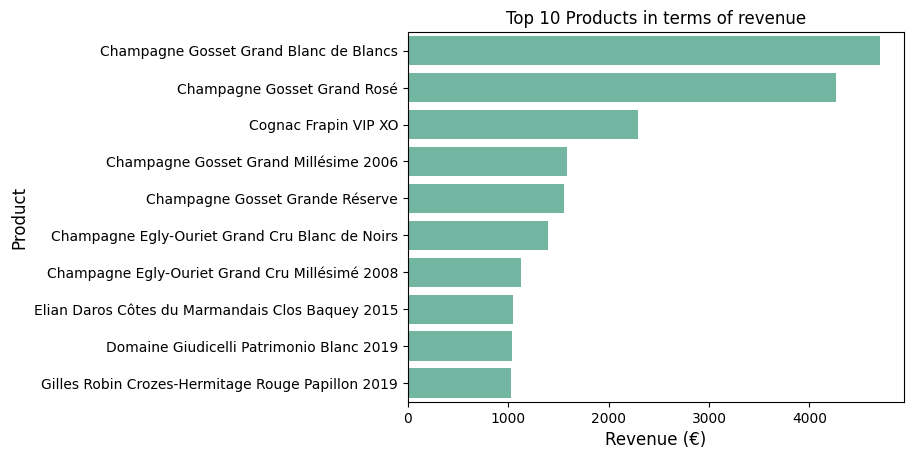

In [123]:
top10 = CA_nonulls.head(10)
sns.barplot(data=top10, y='post_title', x='revenue', estimator=sum)
sns.set_palette('Set2')
plt.title("Top 10 Products in terms of revenue")
plt.xlabel("Revenue (€)", fontsize = 12)
plt.ylabel('Product', fontsize = 12)
plt.show()

# Price analysis

In [114]:
#Check the quantiles for the price column
erp_web['price'].describe()

count    714.000000
mean      32.493137
std       27.810525
min        5.200000
25%       14.100000
50%       23.550000
75%       42.175000
max      225.000000
Name: price, dtype: float64

In [128]:
#Use the IQR method to identify outliers
quartiles = erp_web['price'].quantile([0.25, 0.75])
iqr = quartiles[0.75] - quartiles[0.25]
print('IQR =', iqr)

print('IQR Outliers = Products with a price < €', round(erp_web['price'].quantile(0.25)-(round((iqr*1.5), 2)),2), "or > €", erp_web['price'].quantile(0.75)+(round((iqr*1.5), 2)))

IQR = 28.075000000000003
IQR Outliers = Products with a price < € -28.01 or > € 84.285


Products can't have a negative price, so only the upper range is relevant here for identifying outliers. 

In [129]:
#Find outliers - I will only look at the high prices > €84.285, as prices can't be negative
outliers = erp_web.loc[(erp_web['price'] > erp_web['price'].quantile(0.75) + iqr)]
outliers = outliers[['product_id', 'post_title', 'price']].sort_values(by='price', ascending=False).reset_index().drop(columns='index')

print('Valeurs aberrantes totales =', outliers['product_id'].count())

#Display the outliers
display(outliers.head(50))
display(outliers.tail(6))

Valeurs aberrantes totales = 56


product_id                                         post_title  price
0         4352     Champagne Egly-Ouriet Grand Cru Millésimé 2008  225.0
1         5001     David Duband Charmes-Chambertin Grand Cru 2014  217.5
2         5892  Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...  191.3
3         4402                               Cognac Frapin VIP XO  176.0
4         5767                Camille Giroud Clos de Vougeot 2016  175.0
5         4406  Cognac Frapin Château de Fontpinot 1989 20 Ans...  157.0
6         4904  Domaine Des Croix Corton Charlemagne Grand Cru...  137.0
7         6126             Champagne Gosset Célébris Vintage 2007  135.0
8         4355     Champagne Egly-Ouriet Grand Cru Blanc de Noirs  126.5
9         5612  Domaine Weinbach Gewurztraminer Grand Cru Furs...  124.8
10        5917  Wemyss Malts Single Cask Scotch Whisky Choc 'n...  122.0
11        6213  Domaine des Comtes Lafon Volnay 1er Cru Santen...  121.0
12        6216  Domaine des Comtes Lafon Volnay 1er Cru Champa...  121.0
13        6202  Domaine Clerget Echezeaux Grand Cru En Orveaux...  116.4
14        6212  Domaine des Comtes Lafon Volnay 1er Cru Santen...  115.0
15        6215  Domaine des Comtes Lafon Volnay 1er Cru Champa...  115.0
16        5918  Wemyss Malts Single Cask Scotch Whisky Chai Ca...  114.0
17        5025  Champagne Agrapart &amp; Fils L'Avizoise Extra...  112.0
18        4582  Château de Meursault Puligny-Montrachet 1er Cr...  109.6
19        4404              Cognac Frapin Château de Fontpinot XO  108.5
20        6201  David Duband Chambolle-Musigny 1er Cru Les Sen...  105.6
21        5007  Domaine des Comtes Lafon Volnay 1er Cru Santen...  105.0
22        5008  Domaine des Comtes Lafon Volnay 1er Cru Santen...  105.0
23        4407                          Cognac Frapin Cigar Blend  104.0
24        4903  Domaine Des Croix Corton Grand Cru Les Grèves ...  102.3
25        4115  Zind-Humbrecht Riesling Grand Cru Rangen De Th...  100.0
26        6214  Domaine des Comtes Lafon Volnay 1er Cru Champa...   99.0
27        5916  Wemyss Malts Single Cask Scotch Whisky Chocola...   93.0
28        5565                      Tempier Bandol Cabassaou 2017   92.0
29        4132  Zind-Humbrecht Pinot Gris Grand Cru Rangen De ...   88.4
30        5026  Champagne Agrapart &amp; Fils Minéral Extra Br...   86.8
31        4359  Champagne Larmandier-Bernier Grand Cru Les Che...   85.6
32        5580  Lucien Boillot Puligny-Montrachet 1er Cru Les ...   83.7
33        4337      Champagne Mailly Grand Cru Les Echansons 2007   83.0
34        4046       Pierre Gaillard Côte Rôtie Rose Pourpre 2017   80.0
35        4210  Lucien Boillot Nuits-Saint-Georges 1er Cru Les...   79.8
36        4350    Champagne Egly-Ouriet Grand Cru Extra Brut V.P.   79.5
37        4353          Champagne Egly-Ouriet Grand Cru Brut Rosé   79.5
38        6299  Lucien Boillot Gevrey Chambertin 1er Cru Les C...   78.0
39        4996                Domaine Peyre Rose Marlène N°3 2008   78.0
40        4995                  Domaine Peyre Rose Oro Blanc 2002   78.0
41        4994                Domaine Peyre Rose Syrah Léone 2008   78.0
42        4797            Domaine Peyre Rose Clos des Cistes 2008   78.0
43        4073  Château de Vaudieu Châteauneuf-du-Pape L'Avenu...   77.8
44        4139  Zind-Humbrecht Gewurztraminer Grand Cru Rangen...   77.4
45        4358  Champagne Larmandier-Bernier Grand Cru Vieille...   77.0
46        4631        Marcel Windholtz Eau de Vie de Baie de Houx   76.8
47        6106                Stéphane Tissot Château-Chalon 2011   74.8
48        5951  Domaine de Vaccelli AOP Ajaccio Rouge Granit 1...   74.5
49        5741  Domaine Clerget Chambolle-Musigny Les Charmes ...   73.3

product_id                                         post_title  price
50        6568               Decelle-Villa Chambolle-Musigny 2017   72.0
51        6041  Château de Vaudieu Châteauneuf-du-Pape Amiral ...   71.7
52        4054  Clos du Mont-Olivet Châteauneuf-du-Pape Cuvée ...   71.6
53        5968      Zind-Humbrecht Pinot Gris Clos Windsbuhl 2013   71.5
54        5618  Albert Boxler Riesling Grand Cru Sommerberg "D...   71.3
55        5619  Albert Boxler Riesling Grand Cru Sommerberg "E...   71.3

Mean:
 32.49
Median:
 23.55
Mode:
 0    19.0
Name: price, dtype: float64
Variance:
 772.3420677486682
STD:
 27.79104294100292
Skewness:
 2.58090126300337
Kurtosis:
 10.088392064977288


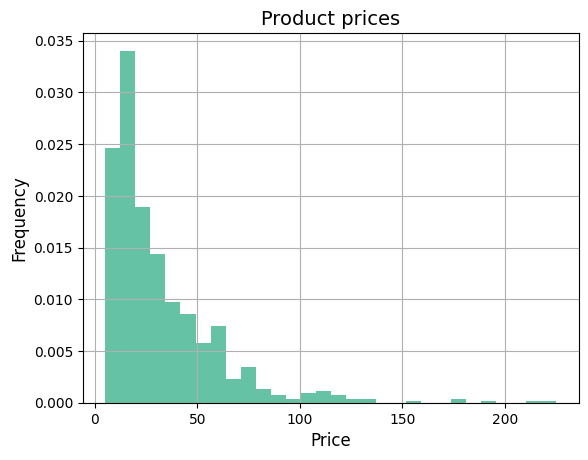

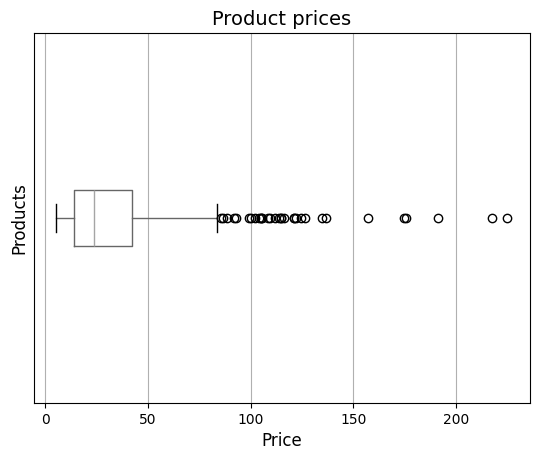

In [130]:
# Display mean, median, mode, variance, standard deviation, skewness and kurtosis
print("Mean:\n",round(erp_web["price"].mean(), 2))
print("Median:\n",erp_web["price"].median())
print("Mode:\n",erp_web["price"].mode())
print("Variance:\n",erp_web["price"].var(ddof=0))
print("STD:\n",erp_web["price"].std(ddof=0))
print("Skewness:\n",erp_web["price"].skew())
print("Kurtosis:\n",erp_web["price"].kurtosis())

#Create histogram with product prices    
erp_web[erp_web["price"].abs() < 250]["price"].hist(density=True,bins=30)
plt.title("Product prices", fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()   

#Create boxplot with product prices 
erp_web.boxplot(column="price", vert=False)
plt.title("Product prices", fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Products', fontsize=12)
plt.yticks([])
plt.show()

Text(0, 0.5, 'Product')

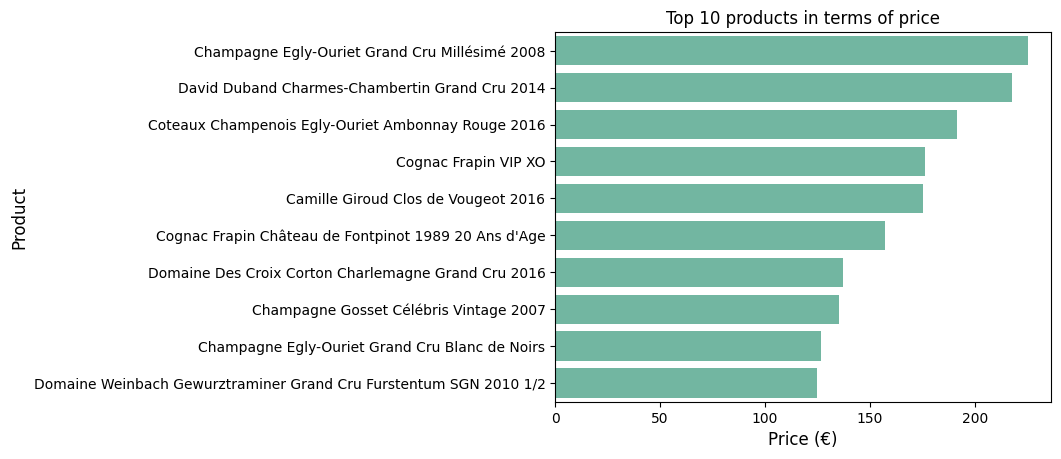

In [131]:
#Les 10 produits avec le prix le plus élevé
top10prix = erp_web.sort_values(by='price', ascending=False).head(10)
sns.barplot(data=top10prix, y='post_title', x='price', estimator=sum)
sns.set_palette('Set2')
plt.title('Top 10 products in terms of price')
plt.xlabel("Price (€)", fontsize = 12)
plt.ylabel('Product', fontsize = 12)